<a href="https://www.kaggle.com/code/sayidheykal/sentiment-analysis-of-simcity-app-reviews?scriptVersionId=207349734" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **PROJECT DESCRIPTION**

**Project Description**:<br>
This project aims to analyze the sentiment of user reviews for the Simcity BuiltId app on the Google Play Store, providing insights into users’ experiences and overall satisfaction with the app. The sentiment analysis will categorize reviews as either positive or negative, allowing us to identify prevalent themes and common user concerns.

**Data Collection**:<br>
The data will be collected by scraping reviews from the Google Play Store using the google-play-scraper Python library. This ensures real-time data acquisition directly from users, reflecting the most current feedback.

**Methodology**:<br>
The project will involve the following components and methodologies:
1. **Sentiment Classification Models**:<br>
Three machine learning and deep learning models will be utilized for sentiment classification:
    * Naive Bayes
    * Decision Tree
    * LSTM (Long Short-Term Memory Neural Network)
2. **Feature Extraction Techniques**: <br>
    * TF-IDF (Term Frequency-Inverse Document Frequency) for transforming text data into numerical features.
    * Word2Vec Word Embeddings for capturing semantic relationships between words.
3. **Data Splitting Strategy**: <br>
To evaluate model performance, the data will be split into training and testing sets using two different ratios:
    * 80/20 split (80% training, 20% testing)
    * 70/30 split (70% training, 30% testing)
4. **Model Training Configurations**: <br>
The following combinations of models, feature extraction, and data splits will be tested:
    * `Naive Bayes` with `TF-IDF` and `80/20` split
    * `Decision Tree` with `TF-IDF` and `70/30` split
    * `LSTM` with `Word2Vec` and `80/20` split

**Project Objective:** <br>
This analysis aims to uncover the user experience with the Simcity BuiltId app by analyzing sentiment patterns in reviews. Insights gained from the sentiment analysis will highlight common positive aspects as well as frequent areas of user dissatisfaction, which can inform app development, customer support strategies, and user engagement.

# **1. Import Library**

In [1]:
!pip install wordcloud

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import string
import re
import requests
import csv
import seaborn as sns

from io import StringIO
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **3. Loading Dataset**

In [3]:
data_input = '/kaggle/input/simcity-buildit-app-reviews/simcity_reviews.csv'
app_reviews_df = pd.read_csv(data_input)

num_of_reviews, num_of_columns = app_reviews_df.shape

print(f'Number of Reviews: {num_of_reviews}')
print(f'Number of Columns: {num_of_columns}')
app_reviews_df.head()

Number of Reviews: 54000
Number of Columns: 11


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,153cae38-9708-4e35-a4c4-92d3078ba8b0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Barangnya mahal2 dan sulit untuk dapet simleon...,4,634,1.57.2.129660,2024-10-16 07:42:13,NaN,NaN,1.57.2.129660
1,ec85c1e0-ac51-4c18-958b-a90914a7e26f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Yang paling disayangkan adalah saat ada tantan...,4,4,1.57.1.129081,2024-10-16 10:08:37,NaN,NaN,1.57.1.129081
2,807166ba-f53a-44f1-a6fe-bb4834ed7d42,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pendapatan uang nya terlalu kecil dan susah. b...,2,16,1.57.1.129081,2024-10-03 13:05:17,NaN,NaN,1.57.1.129081
3,b64cc92b-ea52-4eef-84ef-34ec52326ccc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Offline dari mana'nya coba, udah numpuk resour...",3,19,1.57.1.129081,2024-10-07 09:01:38,NaN,NaN,1.57.1.129081
4,1ae3aae2-ec03-473e-821d-741240df7e1a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"""untuk saran"" 1.ringankan harga tanah 2.kenapa...",3,32,1.57.1.129081,2024-09-21 11:38:00,NaN,NaN,1.57.1.129081


In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              54000 non-null  object 
 1   userName              54000 non-null  object 
 2   userImage             54000 non-null  object 
 3   content               54000 non-null  object 
 4   score                 54000 non-null  int64  
 5   thumbsUpCount         54000 non-null  int64  
 6   reviewCreatedVersion  44900 non-null  object 
 7   at                    54000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            44900 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 4.5+ MB


# **4. Data Cleansing**

## **4.1 Handling Missing Values**

In [5]:
# Retrieve number of missing values for each columns
num_missing = app_reviews_df.isna().sum()

# Calculate percentage of missing values for each columns
percentage_missing = round(num_missing / app_reviews_df.shape[0] * 100, 3)

print(f'percentage of missing values \n{percentage_missing}\n\nNumber of missing values:\n{num_missing}')

percentage of missing values 
reviewId                  0.000
userName                  0.000
userImage                 0.000
content                   0.000
score                     0.000
thumbsUpCount             0.000
reviewCreatedVersion     16.852
at                        0.000
replyContent            100.000
repliedAt               100.000
appVersion               16.852
dtype: float64

Number of missing values:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     9100
at                          0
replyContent            54000
repliedAt               54000
appVersion               9100
dtype: int64


There is different number of missing in some columns. However, the `content` value has around `0.005%` of missing values which is the column that we will analize. Thus, with the little amount of missing value, we can safely remove it. There are some steps we will do as following:

**STRATEGY**
1. Drop all the columns with the missing values except `content` column using `drop()` method.
2. Remove the rows contain the missing values of `content` column using `dropna()` method.

The reason we drop all columns with missing values is to ensure we don't remove all rows that contains the missing values, which there is 99 percent of the dataset contain missing values.

In [6]:
# Store the columns that need to be dropped
drop_columns = ['reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion']

# drop the listed columns
df_cleaned = app_reviews_df.drop(columns=drop_columns)

# drop the missing values from content columns
df_cleaned = df_cleaned.dropna()

# check percentage of missing values after dropping
percentage_missing = df_cleaned.isna().sum() / df_cleaned.shape[0] * 100

print(f'Percentage of missing values: \n{percentage_missing}')

Percentage of missing values: 
reviewId         0.0
userName         0.0
userImage        0.0
content          0.0
score            0.0
thumbsUpCount    0.0
at               0.0
dtype: float64


Now we free from missing values

In [7]:
df_cleaned.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,at
0,153cae38-9708-4e35-a4c4-92d3078ba8b0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Barangnya mahal2 dan sulit untuk dapet simleon...,4,634,2024-10-16 07:42:13
1,ec85c1e0-ac51-4c18-958b-a90914a7e26f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Yang paling disayangkan adalah saat ada tantan...,4,4,2024-10-16 10:08:37
2,807166ba-f53a-44f1-a6fe-bb4834ed7d42,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pendapatan uang nya terlalu kecil dan susah. b...,2,16,2024-10-03 13:05:17
3,b64cc92b-ea52-4eef-84ef-34ec52326ccc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Offline dari mana'nya coba, udah numpuk resour...",3,19,2024-10-07 09:01:38
4,1ae3aae2-ec03-473e-821d-741240df7e1a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"""untuk saran"" 1.ringankan harga tanah 2.kenapa...",3,32,2024-09-21 11:38:00


## **4.2 Handling Duplicated Rows**

In [8]:
# retrieve number of duplicate rows
num_duplicated = df_cleaned.duplicated().sum() 

# Print the number of duplicate
print(f'number of duplicate rows: {num_duplicated}')

number of duplicate rows: 0


# **5. Preprocessing**

The most important preprocessing for sentiment analysis that our focus on the compound words that describes the sentimental of the text. So, punctuation like `?`, `!`, `#`, or number, does not describe anything at all, or lowercase and uppercase should be Threatened as the same, for example, `Book` and `book` should be the same. and so on. Thus, clean the content of those problems is needed to be done on preprocessing. We will do the steps below:

**STRATEGY**
1. `Cleaning Text`, such as removing the hastags, links, mentions, punctuation.
2. `Lowercasing` all the content
4.  Fix `Slangwords`.
5. `Tokenizing` all the words, divide the sentence into words tokenized.
6. Remove all the `Stopwords`.
8. Restructured to sentence

## **5.1 Cleaning Text**

In [9]:
def cleaning_content(content):
    # remove numbers
    content = re.sub(r'[\d]+', '', content) 
    
    # remove hashtag
    content = re.sub(r'#[\w]+', '', content) 
    
    # remove mentions
    content = re.sub(r'@[\w]+', '', content) 
    
    # remove link
    content = re.sub(r"http[\S]+", '', content) 
    
    # replace new line into space
    content = content.replace('\n', ' ')
    
    # remove all punctuations
    punct = list(string.punctuation)
    content = [i for i in content if i not in punct]
    content = ''.join(content)

    # remove characters space from both left and right content
    content = content.strip(' ') 
    
    return content

In [10]:
# applying cleaning function for content columns, and store it to another column called `text_cleaned`
df_cleaned['content_cleaned'] = df_cleaned['content'].apply(cleaning_content)

# print content example
print(f'\33[94m--------- | Content cleaned | ---------\n\33[0m')
print(f"{df_cleaned['content_cleaned'].iloc[0]}\n")

--------- | Content cleaned | ---------

Barangnya mahal dan sulit untuk dapet simleonnya Udah gitu harga jalanannya mahal banget buset Game nya seakan untuk yg bermodal gede aja wkwkw Dari segi grafik ya gamenya cukup bagus sih sebenernya Pas teken kereta kita bisa ikutin keretanya Coba aja kendaraan lain juga bisa Kadang masih suka ngebug Terus ekspansi wilayah sama perluas gudang susah bener dah terlalu repot dan banyak banget Pemain yang cheat di war clubs tolong ditindaklanjuti



## 5.2 CaseFolding

In [11]:
def casefolding(content):
    return content.lower()

In [12]:
# lowercase the content
df_cleaned['content_lower'] = df_cleaned['content_cleaned'].apply(casefolding)

# print content example
print(f'\33[94m--------- | lowercase content | ---------\n\33[0m')
print(f"{df_cleaned['content_lower'].iloc[0]}\n")

--------- | lowercase content | ---------

barangnya mahal dan sulit untuk dapet simleonnya udah gitu harga jalanannya mahal banget buset game nya seakan untuk yg bermodal gede aja wkwkw dari segi grafik ya gamenya cukup bagus sih sebenernya pas teken kereta kita bisa ikutin keretanya coba aja kendaraan lain juga bisa kadang masih suka ngebug terus ekspansi wilayah sama perluas gudang susah bener dah terlalu repot dan banyak banget pemain yang cheat di war clubs tolong ditindaklanjuti



## **5.3 Slangwords**

In [13]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def slangwords_fixer(content):
    words_fixed = []

    # iterate all the word in content
    for word in content.split():
        # check if word exists in slangwords dictionary
        if word.lower() in slangwords:
            # append the fixed slangword into words_fixed list
            words_fixed.append(slangwords[word.lower()])
        else:
            # append the original words
            words_fixed.append(word.lower())

    # joining words to sentence
    content_fixed = ' '.join(words_fixed)

    # replace wkwkw to ketawa for more flexibelity
    content_fixed = re.sub(r'\b[wk]+\b', 'ketawa', content)

    return content_fixed

In [14]:
# apply slangwords removing function for each content
df_cleaned['no_slang'] = df_cleaned['content_lower'].apply(slangwords_fixer)

# print content example
print(f'\33[94m--------- | no slang content | ---------\n\33[0m')
print(f"{df_cleaned['no_slang'].iloc[0]}\n")

--------- | no slang content | ---------

barangnya mahal dan sulit untuk dapet simleonnya udah gitu harga jalanannya mahal banget buset game nya seakan untuk yg bermodal gede aja ketawa dari segi grafik ya gamenya cukup bagus sih sebenernya pas teken kereta kita bisa ikutin keretanya coba aja kendaraan lain juga bisa kadang masih suka ngebug terus ekspansi wilayah sama perluas gudang susah bener dah terlalu repot dan banyak banget pemain yang cheat di war clubs tolong ditindaklanjuti



## **5.4 Tokenize**

In [15]:
def tokenize(content):
    return word_tokenize(content)

In [16]:
# applying tokenizing for each rows of lowercase content
df_cleaned['content_tokenized'] = df_cleaned['no_slang'].apply(tokenize)

# print content example
print(f'\33[94m--------- | Tokenized content | ---------\n\33[0m')
print(f"{df_cleaned['content_tokenized'].iloc[0]}\n")

--------- | Tokenized content | ---------

['barangnya', 'mahal', 'dan', 'sulit', 'untuk', 'dapet', 'simleonnya', 'udah', 'gitu', 'harga', 'jalanannya', 'mahal', 'banget', 'buset', 'game', 'nya', 'seakan', 'untuk', 'yg', 'bermodal', 'gede', 'aja', 'ketawa', 'dari', 'segi', 'grafik', 'ya', 'gamenya', 'cukup', 'bagus', 'sih', 'sebenernya', 'pas', 'teken', 'kereta', 'kita', 'bisa', 'ikutin', 'keretanya', 'coba', 'aja', 'kendaraan', 'lain', 'juga', 'bisa', 'kadang', 'masih', 'suka', 'ngebug', 'terus', 'ekspansi', 'wilayah', 'sama', 'perluas', 'gudang', 'susah', 'bener', 'dah', 'terlalu', 'repot', 'dan', 'banyak', 'banget', 'pemain', 'yang', 'cheat', 'di', 'war', 'clubs', 'tolong', 'ditindaklanjuti']



## **5.5 Stop Words Remover**

In [17]:
def filter_stopwords(content):
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])

    filtered = []
    for word in content:
        if word not in list_stopwords:
            filtered.append(word)

    return filtered

In [18]:
# applying tokenizing for each rows of lowercase content
df_cleaned['without_stopwords'] = df_cleaned['content_tokenized'].apply(filter_stopwords)

# print content example
print(f'\33[94m--------- | without stopwords content | ---------\n\33[0m')
print(f"{df_cleaned['without_stopwords'].iloc[0]}\n")

--------- | without stopwords content | ---------

['barangnya', 'mahal', 'sulit', 'dapet', 'simleonnya', 'udah', 'gitu', 'harga', 'jalanannya', 'mahal', 'banget', 'buset', 'game', 'seakan', 'yg', 'bermodal', 'gede', 'aja', 'ketawa', 'segi', 'grafik', 'gamenya', 'bagus', 'sebenernya', 'pas', 'teken', 'kereta', 'ikutin', 'keretanya', 'coba', 'aja', 'kendaraan', 'kadang', 'suka', 'ngebug', 'ekspansi', 'wilayah', 'perluas', 'gudang', 'susah', 'bener', 'dah', 'repot', 'banget', 'pemain', 'cheat', 'war', 'clubs', 'tolong', 'ditindaklanjuti']



In [19]:
def to_sentence(content):
    return ' '.join(content)

In [20]:
df_cleaned['text_preprocessed'] = df_cleaned['without_stopwords'].apply(to_sentence)

# print content example
print(f'\33[94m--------- | preprocessed content | ---------\n\33[0m')
print(f"{df_cleaned['text_preprocessed'].iloc[0]}\n")

--------- | preprocessed content | ---------

barangnya mahal sulit dapet simleonnya udah gitu harga jalanannya mahal banget buset game seakan yg bermodal gede aja ketawa segi grafik gamenya bagus sebenernya pas teken kereta ikutin keretanya coba aja kendaraan kadang suka ngebug ekspansi wilayah perluas gudang susah bener dah repot banget pemain cheat war clubs tolong ditindaklanjuti



# **6. Content Labeling**

Content labeling based on word lexicon either if it is positive or negative, with each word has a score, it's negative score if it's negative word and positive score if it's positive word

## **6.1 Request positive lexicon**

In [21]:
# initiate the dictionary variable to store positive lexicon score
lexicon_pos = dict()

url_req = 'https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/positive.tsv'
response = requests.get(url_req)

if response.status_code == 200:
    # read csv file from response
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    
    # skip header of table
    reader.__next__()

    # iterate through the response
    for line in reader:
        lexicon_pos[line[0]] = int(line[1])

else:
    print(f'failed to request {url_req}')

In [22]:
from itertools import islice
dict(islice(lexicon_pos.items(), 5))

{'hai': 3, 'merekam': 2, 'ekstensif': 3, 'paripurna': 1, 'detail': 2}

## **6.2 Request negative lexicon**

In [23]:
# initiate the dictionary to store negative lexicion score
lexicon_neg = dict()

url_req = 'https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/negative.tsv'
response = requests.get(url_req)

if response.status_code == 200:
    # read csv file from response
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    
    # skip header of table
    reader.__next__()

    # iterate through the response
    for line in reader:
        lexicon_neg[line[0]] = int(line[1])

else:
    print(f'failed to request {url_req}')

In [24]:
from itertools import islice
dict(islice(lexicon_neg.items(), 5))

{'putus tali gantung': -2,
 'gelebah': -2,
 'gobar hati': -2,
 'tersentuh (perasaan)': -1,
 'isak': -5}

## **6.3 Label Analysis**

In [25]:
def analysis_label(content):
    # iniitatate variable to store the final score
    score = 0

    # iterate each word to identify if it's negative or positive word
    for word in content.split():
        # if the word in the positive lexicon
        if word in lexicon_pos:
            # add the score by word positive score
            score += lexicon_pos[word]
            
        # if the word in the negative lexicon
        elif word in lexicon_neg:
            # add the score by word negative score
            score += lexicon_neg[word]


    # identify lebel based on final score
    if score > 0:
        return 'positive'
    else:
        return 'negative'


In [26]:
# copying the cleaned dataset so we can have the original of cleaned dataset
df_labeled = df_cleaned.copy()

# apply each content analysis to label either negative or positive
df_labeled['labels'] = df_labeled['text_preprocessed'].apply(analysis_label)

# count the number of negative and postiive label
df_labeled['labels'].value_counts()

labels
positive    36951
negative    17049
Name: count, dtype: int64

In [27]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviewId           54000 non-null  object
 1   userName           54000 non-null  object
 2   userImage          54000 non-null  object
 3   content            54000 non-null  object
 4   score              54000 non-null  int64 
 5   thumbsUpCount      54000 non-null  int64 
 6   at                 54000 non-null  object
 7   content_cleaned    54000 non-null  object
 8   content_lower      54000 non-null  object
 9   no_slang           54000 non-null  object
 10  content_tokenized  54000 non-null  object
 11  without_stopwords  54000 non-null  object
 12  text_preprocessed  54000 non-null  object
 13  labels             54000 non-null  object
dtypes: int64(2), object(12)
memory usage: 5.8+ MB


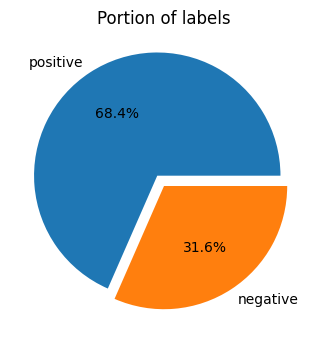

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))

data = df_labeled['labels'].value_counts().tolist()
labels = df_labeled['labels'].value_counts().index.tolist()

ax.pie(x=data, labels=labels, explode=(0.1, 0), autopct='%1.1f%%')
ax.set_title('Portion of labels')
plt.show()

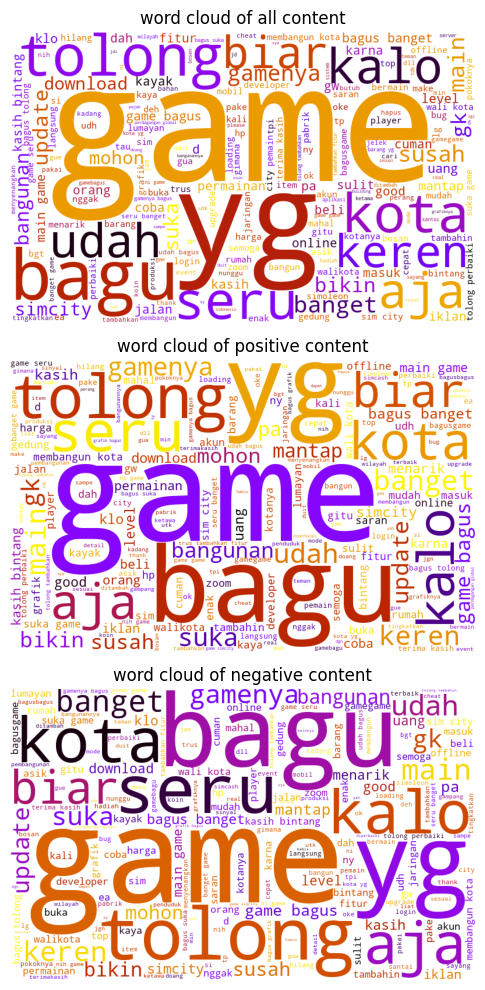

In [29]:
# initiate the variable to store all words or positive and negative labeled
words_list = ''
words_positive = ''
words_negative = ''

# 
for content in df_cleaned['text_preprocessed']:
    for word in content:
        words_list += word

positive_contents = df_labeled['text_preprocessed'][df_labeled['labels'] == 'positive']
for content in positive_contents:
    for word in content:
        words_positive += word

negative_contents = df_labeled['text_preprocessed'][df_labeled['labels'] == 'negative']
for content in positive_contents:
    for word in content:
        words_negative += word


fig, ax = plt.subplots(figsize=(25,10), nrows=3, ncols=1)
ax = ax.flatten()


wc = WordCloud(background_color='white', colormap='gnuplot', min_font_size=5, height=500, width=800).generate(words_list)
ax[0].imshow(wc)
ax[0].axis('off')
ax[0].set_title('word cloud of all content')

wc_pos = WordCloud(background_color='white', colormap='gnuplot', min_font_size=5, height=500, width=800).generate(words_positive)
ax[1].imshow(wc_pos)
ax[1].axis('off')
ax[1].set_title('word cloud of positive content')

wc_neg = WordCloud(background_color='white', colormap='gnuplot', min_font_size=5, height=500, width=800).generate(words_negative)
ax[2].imshow(wc_neg)
ax[2].axis('off')
ax[2].set_title('word cloud of negative content')

plt.tight_layout()

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
corpus = vectorizer.fit_transform(df_cleaned['text_preprocessed'])
corpus_df = pd.DataFrame(corpus.toarray(), columns=vectorizer.get_feature_names_out())
corpus_df = corpus_df.sum().reset_index(name='jumlah')
corpus_df = corpus_df.sort_values(ascending=False, by='jumlah').head(20)
corpus_df

,index,jumlah
1514,bagus,4555.583741
8196,game,3326.564095
8952,good,2743.539107
12348,keren,1930.448008
15260,mantap,1783.409977
23790,seru,1392.562122
19134,ok,1317.905373
25081,suka,1153.872773
1961,banget,987.815904
8275,gamenya,933.113727


Text(0.5, 1.0, 'Most frequent words')

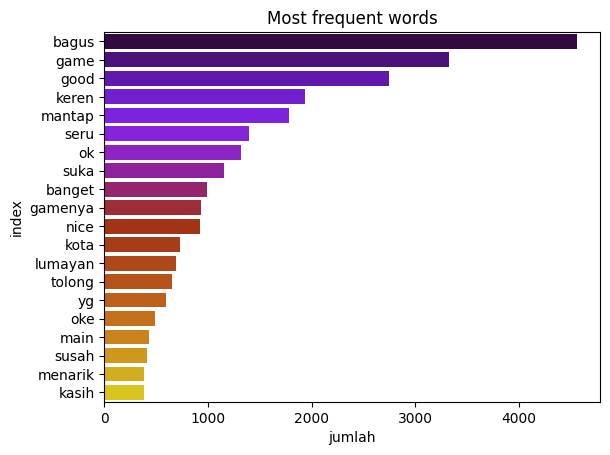

In [31]:
sns.barplot(y='index', x='jumlah', data=corpus_df, palette='gnuplot')

plt.title('Most frequent words')

# **7. Model Training**

As we've planned before that the combination of models perference that we will use, there are:

1. `Naive Bayes` with `TF-IDF` and `80/20` split
2. `Decision Tree` with `TF-IDF` and `70/30` split
3. `LSTM` with `Word2Vec` and `80/20` split

**STRATEGY**
1. Extract features to `TF-IDF` and `Word2Vec`
2. Splitting data to `80/20` and `70/30`.
3. Create a model combination as ordered above

## **7.1 Split Data**

In [32]:
X = df_labeled['text_preprocessed']
y = df_labeled['labels']

X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, 
                                                                 test_size=0.2, 
                                                                 stratify=y, random_state=42)

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y,
                                                               test_size=0.3,
                                                               stratify=y,
                                                               random_state=42)

print(f'---split 80/20---\n\33[32mtrain: {X_train_80.shape[0]}\n\33[33mtest: {X_test_20.shape[0]}\33[0m\n')
print(f'---split 70/30---\n\33[32mtrain: {X_train_70.shape[0]}\n\33[33mtest: {X_test_30.shape[0]}\33[0m')

---split 80/20---
train: 43200
test: 10800

---split 70/30---
train: 37800
test: 16200


## **7.2 Feature Extraction**

In [33]:
def tfidf_vector(X):
    tfidf = TfidfVectorizer(max_features=110)
    X_tfidf =  tfidf.fit_transform(X)
    return X_tfidf

def w2v_model(X):
    X_tokenized = X.apply(word_tokenize)
    model_w2v = Word2Vec(sentences=X_tokenized, vector_size=100, window=5, min_count=1, workers=3)
    return model_w2v

## **7.3 `Naive Bayes` with `TF-IDF` and `80/20` split**

(10800, 110)
[learning_curve] Training set sizes: [ 2880  9360 15840 22320 28800]
[CV] END ..................., score=(train=0.744, test=0.733) total time=   0.0s
[CV] END ..................., score=(train=0.740, test=0.732) total time=   0.1s
[CV] END ..................., score=(train=0.738, test=0.734) total time=   0.1s
[CV] END ..................., score=(train=0.735, test=0.733) total time=   0.1s
[CV] END ..................., score=(train=0.735, test=0.733) total time=   0.1s
[CV] END ..................., score=(train=0.739, test=0.732) total time=   0.0s
[CV] END ..................., score=(train=0.747, test=0.734) total time=   0.1s
[CV] END ..................., score=(train=0.740, test=0.733) total time=   0.1s
[CV] END ..................., score=(train=0.736, test=0.733) total time=   0.1s
[CV] END ..................., score=(train=0.736, test=0.733) total time=   0.1s
[CV] END ..................., score=(train=0.739, test=0.729) total time=   0.0s
[CV] END ..................

Text(0.5, 1.0, 'NB Learning Curve')

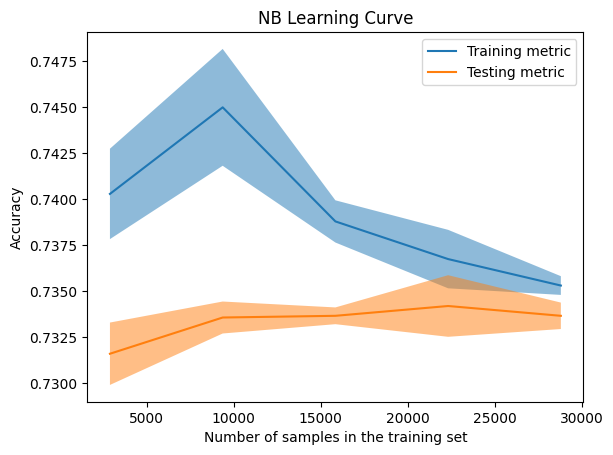

In [34]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
nb = MultinomialNB()

X_train_tfidf = tfidf_vector(X_train_80)
X_test_tfidf = tfidf_vector(X_test_20)

print(X_test_tfidf.shape)

nb.fit(X_train_tfidf, y_train_80)

y_pred_train_nb = nb.predict(X_train_tfidf)
y_pred_test_nb = nb.predict(X_test_tfidf)

accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train_80)
accurcay_test_nb = accuracy_score(y_pred_test_nb, y_test_20)

train_size_nb, train_score_nb, test_score_nb = learning_curve(nb, 
                                                              X=X_train_tfidf, y=y_train_80, 
                                                              cv=3, verbose=3)

LearningCurveDisplay.from_estimator(nb, X=X_train_tfidf, y=y_train_80, cv=3,
                                    score_type='both', score_name="Accuracy")
plt.title('NB Learning Curve')

In [35]:
print(f'accuracy train: {accuracy_train_nb}')
print(f'accuracy test: {accurcay_test_nb}')

accuracy train: 0.7356018518518519
accuracy test: 0.633425925925926
